# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [53]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [54]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [55]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [56]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [57]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [58]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [59]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.499438831759983 -2.796391605722153
actions: 1 0
rewards: 1.0 1.0


In [60]:
actions[:10]

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [61]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [62]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [63]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [64]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [65]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rate

In [66]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [67]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [69]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rate):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob_actions * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # nextQs
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, 
                                                                    labels=rate*tf.ones_like(targetQs))) # GAN
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, 
                                                                     labels=rate*tf.ones_like(targetQs))) #GAN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [70]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [71]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [72]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [73]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [74]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
g_learning_rate = 0.0001         # Q-network learning rate
d_learning_rate = 0.00001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [75]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [76]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [77]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    rate = 0 # success rate based on total reward/R

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # success rate
        gloss_batch, dlossA_batch, dlossQ_batch = [], [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 0.001
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, _, _ = sess.run([model.g_loss, model.d_lossA,
                                            model.g_opt, model.d_optA],
                                           feed_dict = {model.states: states, 
                                                        model.actions: actions,
                                                        model.targetQs: targetQs, 
                                                        model.rate: rate})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        rate = total_reward/500
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 rate:0.0000 R:23.0000 gloss:0.7507 dlossA:1.5517 dlossQ:1.7415 exploreP:1.0000
Episode:1 meanR:18.0000 rate:0.0460 R:13.0000 gloss:0.7501 dlossA:1.5358 dlossQ:1.7437 exploreP:1.0000
Episode:2 meanR:19.3333 rate:0.0260 R:22.0000 gloss:0.7497 dlossA:1.5440 dlossQ:1.7374 exploreP:1.0000
Episode:3 meanR:17.7500 rate:0.0440 R:13.0000 gloss:0.7512 dlossA:1.5372 dlossQ:1.7455 exploreP:1.0000
Episode:4 meanR:19.0000 rate:0.0260 R:24.0000 gloss:0.7497 dlossA:1.5458 dlossQ:1.7308 exploreP:1.0000
Episode:5 meanR:19.1667 rate:0.0480 R:20.0000 gloss:0.7521 dlossA:1.5380 dlossQ:1.7474 exploreP:1.0000
Episode:6 meanR:19.0000 rate:0.0400 R:18.0000 gloss:0.7505 dlossA:1.5395 dlossQ:1.7403 exploreP:1.0000
Episode:7 meanR:18.7500 rate:0.0360 R:17.0000 gloss:0.7473 dlossA:1.5389 dlossQ:1.7319 exploreP:1.0000
Episode:8 meanR:17.8889 rate:0.0340 R:11.0000 gloss:0.7473 dlossA:1.5381 dlossQ:1.7358 exploreP:1.0000
Episode:9 meanR:17.7000 rate:0.0220 R:16.0000 gloss:0.7477 dlossA:1.5404 

Episode:79 meanR:19.3750 rate:0.0440 R:32.0000 gloss:0.7543 dlossA:1.5425 dlossQ:1.7468 exploreP:0.9998
Episode:80 meanR:19.2716 rate:0.0640 R:11.0000 gloss:0.7533 dlossA:1.5343 dlossQ:1.7451 exploreP:0.9998
Episode:81 meanR:19.2561 rate:0.0220 R:18.0000 gloss:0.7534 dlossA:1.5509 dlossQ:1.7417 exploreP:0.9998
Episode:82 meanR:19.4819 rate:0.0360 R:38.0000 gloss:0.7535 dlossA:1.5434 dlossQ:1.7461 exploreP:0.9998
Episode:83 meanR:19.4167 rate:0.0760 R:14.0000 gloss:0.7537 dlossA:1.5290 dlossQ:1.7504 exploreP:0.9998
Episode:84 meanR:19.4118 rate:0.0280 R:19.0000 gloss:0.7550 dlossA:1.5494 dlossQ:1.7452 exploreP:0.9998
Episode:85 meanR:19.4651 rate:0.0380 R:24.0000 gloss:0.7569 dlossA:1.5458 dlossQ:1.7553 exploreP:0.9998
Episode:86 meanR:19.6092 rate:0.0480 R:32.0000 gloss:0.7569 dlossA:1.5433 dlossQ:1.7504 exploreP:0.9998
Episode:87 meanR:19.5114 rate:0.0640 R:11.0000 gloss:0.7538 dlossA:1.5377 dlossQ:1.7378 exploreP:0.9998
Episode:88 meanR:19.5056 rate:0.0220 R:19.0000 gloss:0.7550 dlos

Episode:158 meanR:22.5500 rate:0.0820 R:22.0000 gloss:0.7588 dlossA:1.5348 dlossQ:1.7522 exploreP:0.9997
Episode:159 meanR:22.4200 rate:0.0440 R:11.0000 gloss:0.7613 dlossA:1.5519 dlossQ:1.7479 exploreP:0.9997
Episode:160 meanR:22.2300 rate:0.0220 R:10.0000 gloss:0.7603 dlossA:1.5574 dlossQ:1.7497 exploreP:0.9997
Episode:161 meanR:22.2700 rate:0.0200 R:18.0000 gloss:0.7591 dlossA:1.5567 dlossQ:1.7467 exploreP:0.9997
Episode:162 meanR:22.2400 rate:0.0360 R:9.0000 gloss:0.7555 dlossA:1.5474 dlossQ:1.7379 exploreP:0.9997
Episode:163 meanR:22.2000 rate:0.0180 R:13.0000 gloss:0.7609 dlossA:1.5554 dlossQ:1.7595 exploreP:0.9997
Episode:164 meanR:22.2100 rate:0.0260 R:13.0000 gloss:0.7581 dlossA:1.5539 dlossQ:1.7474 exploreP:0.9997
Episode:165 meanR:22.4900 rate:0.0260 R:40.0000 gloss:0.7570 dlossA:1.5515 dlossQ:1.7499 exploreP:0.9997
Episode:166 meanR:22.5100 rate:0.0800 R:12.0000 gloss:0.7560 dlossA:1.5321 dlossQ:1.7498 exploreP:0.9997
Episode:167 meanR:22.4000 rate:0.0240 R:21.0000 gloss:0.

Episode:237 meanR:21.6600 rate:0.0240 R:20.0000 gloss:0.7598 dlossA:1.5550 dlossQ:1.7536 exploreP:0.9995
Episode:238 meanR:22.3700 rate:0.0400 R:87.0000 gloss:0.7597 dlossA:1.5496 dlossQ:1.7521 exploreP:0.9995
Episode:239 meanR:22.4900 rate:0.1740 R:26.0000 gloss:0.7629 dlossA:1.5063 dlossQ:1.7586 exploreP:0.9995
Episode:240 meanR:22.5500 rate:0.0520 R:28.0000 gloss:0.7624 dlossA:1.5487 dlossQ:1.7524 exploreP:0.9995
Episode:241 meanR:22.6800 rate:0.0560 R:29.0000 gloss:0.7632 dlossA:1.5516 dlossQ:1.7465 exploreP:0.9995
Episode:242 meanR:22.7900 rate:0.0580 R:26.0000 gloss:0.7643 dlossA:1.5521 dlossQ:1.7455 exploreP:0.9995
Episode:243 meanR:22.7200 rate:0.0520 R:25.0000 gloss:0.7631 dlossA:1.5498 dlossQ:1.7578 exploreP:0.9995
Episode:244 meanR:22.6900 rate:0.0500 R:11.0000 gloss:0.7650 dlossA:1.5549 dlossQ:1.7445 exploreP:0.9995
Episode:245 meanR:22.7200 rate:0.0220 R:32.0000 gloss:0.7631 dlossA:1.5627 dlossQ:1.7467 exploreP:0.9995
Episode:246 meanR:22.7300 rate:0.0640 R:25.0000 gloss:0

Episode:316 meanR:25.1700 rate:0.0400 R:17.0000 gloss:0.7641 dlossA:1.5561 dlossQ:1.7536 exploreP:0.9993
Episode:317 meanR:24.9700 rate:0.0340 R:14.0000 gloss:0.7632 dlossA:1.5541 dlossQ:1.7633 exploreP:0.9993
Episode:318 meanR:25.2500 rate:0.0280 R:38.0000 gloss:0.7635 dlossA:1.5579 dlossQ:1.7531 exploreP:0.9993
Episode:319 meanR:25.5300 rate:0.0760 R:44.0000 gloss:0.7641 dlossA:1.5430 dlossQ:1.7552 exploreP:0.9993
Episode:320 meanR:25.1800 rate:0.0880 R:17.0000 gloss:0.7653 dlossA:1.5387 dlossQ:1.7600 exploreP:0.9993
Episode:321 meanR:25.2300 rate:0.0340 R:20.0000 gloss:0.7625 dlossA:1.5559 dlossQ:1.7517 exploreP:0.9993
Episode:322 meanR:25.0400 rate:0.0400 R:19.0000 gloss:0.7640 dlossA:1.5520 dlossQ:1.7613 exploreP:0.9993
Episode:323 meanR:25.3300 rate:0.0380 R:42.0000 gloss:0.7622 dlossA:1.5555 dlossQ:1.7437 exploreP:0.9993
Episode:324 meanR:25.3000 rate:0.0840 R:11.0000 gloss:0.7636 dlossA:1.5385 dlossQ:1.7606 exploreP:0.9993
Episode:325 meanR:25.1000 rate:0.0220 R:25.0000 gloss:0

Episode:395 meanR:24.6400 rate:0.0600 R:16.0000 gloss:0.7637 dlossA:1.5500 dlossQ:1.7501 exploreP:0.9991
Episode:396 meanR:24.6100 rate:0.0320 R:14.0000 gloss:0.7612 dlossA:1.5566 dlossQ:1.7533 exploreP:0.9991
Episode:397 meanR:24.5900 rate:0.0280 R:14.0000 gloss:0.7628 dlossA:1.5574 dlossQ:1.7562 exploreP:0.9991
Episode:398 meanR:24.5700 rate:0.0280 R:20.0000 gloss:0.7647 dlossA:1.5599 dlossQ:1.7565 exploreP:0.9991
Episode:399 meanR:24.1500 rate:0.0400 R:11.0000 gloss:0.7645 dlossA:1.5526 dlossQ:1.7641 exploreP:0.9991
Episode:400 meanR:24.2500 rate:0.0220 R:23.0000 gloss:0.7631 dlossA:1.5607 dlossQ:1.7547 exploreP:0.9991
Episode:401 meanR:24.2000 rate:0.0460 R:23.0000 gloss:0.7639 dlossA:1.5533 dlossQ:1.7559 exploreP:0.9991
Episode:402 meanR:24.2300 rate:0.0460 R:19.0000 gloss:0.7651 dlossA:1.5520 dlossQ:1.7644 exploreP:0.9991
Episode:403 meanR:24.2600 rate:0.0380 R:30.0000 gloss:0.7657 dlossA:1.5557 dlossQ:1.7646 exploreP:0.9991
Episode:404 meanR:24.2500 rate:0.0600 R:12.0000 gloss:0

Episode:474 meanR:23.0600 rate:0.0520 R:27.0000 gloss:0.7634 dlossA:1.5475 dlossQ:1.7594 exploreP:0.9989
Episode:475 meanR:22.9800 rate:0.0540 R:23.0000 gloss:0.7618 dlossA:1.5478 dlossQ:1.7572 exploreP:0.9989
Episode:476 meanR:22.5200 rate:0.0460 R:19.0000 gloss:0.7624 dlossA:1.5498 dlossQ:1.7616 exploreP:0.9989
Episode:477 meanR:22.4900 rate:0.0380 R:12.0000 gloss:0.7650 dlossA:1.5573 dlossQ:1.7560 exploreP:0.9989
Episode:478 meanR:22.3400 rate:0.0240 R:18.0000 gloss:0.7630 dlossA:1.5591 dlossQ:1.7554 exploreP:0.9989
Episode:479 meanR:22.4700 rate:0.0360 R:31.0000 gloss:0.7619 dlossA:1.5539 dlossQ:1.7571 exploreP:0.9989
Episode:480 meanR:22.5400 rate:0.0620 R:18.0000 gloss:0.7608 dlossA:1.5420 dlossQ:1.7595 exploreP:0.9989
Episode:481 meanR:22.7900 rate:0.0360 R:61.0000 gloss:0.7625 dlossA:1.5525 dlossQ:1.7615 exploreP:0.9989
Episode:482 meanR:23.0200 rate:0.1220 R:39.0000 gloss:0.7619 dlossA:1.5243 dlossQ:1.7575 exploreP:0.9989
Episode:483 meanR:23.6100 rate:0.0780 R:74.0000 gloss:0

Episode:554 meanR:23.4500 rate:0.0260 R:14.0000 gloss:0.7648 dlossA:1.5623 dlossQ:1.7549 exploreP:0.9987
Episode:555 meanR:23.6600 rate:0.0280 R:36.0000 gloss:0.7658 dlossA:1.5608 dlossQ:1.7598 exploreP:0.9987
Episode:556 meanR:23.5300 rate:0.0720 R:10.0000 gloss:0.7610 dlossA:1.5417 dlossQ:1.7545 exploreP:0.9987
Episode:557 meanR:23.4600 rate:0.0200 R:10.0000 gloss:0.7647 dlossA:1.5659 dlossQ:1.7567 exploreP:0.9987
Episode:558 meanR:23.5200 rate:0.0200 R:27.0000 gloss:0.7616 dlossA:1.5595 dlossQ:1.7561 exploreP:0.9987
Episode:559 meanR:23.6200 rate:0.0540 R:23.0000 gloss:0.7629 dlossA:1.5459 dlossQ:1.7645 exploreP:0.9987
Episode:560 meanR:23.6900 rate:0.0460 R:20.0000 gloss:0.7649 dlossA:1.5521 dlossQ:1.7594 exploreP:0.9987
Episode:561 meanR:23.5200 rate:0.0400 R:13.0000 gloss:0.7614 dlossA:1.5513 dlossQ:1.7607 exploreP:0.9987
Episode:562 meanR:23.5400 rate:0.0260 R:16.0000 gloss:0.7651 dlossA:1.5590 dlossQ:1.7633 exploreP:0.9987
Episode:563 meanR:23.4400 rate:0.0320 R:20.0000 gloss:0

Episode:633 meanR:21.2500 rate:0.0260 R:50.0000 gloss:0.7647 dlossA:1.5578 dlossQ:1.7690 exploreP:0.9986
Episode:634 meanR:21.0100 rate:0.1000 R:10.0000 gloss:0.7654 dlossA:1.5339 dlossQ:1.7667 exploreP:0.9986
Episode:635 meanR:20.9600 rate:0.0200 R:24.0000 gloss:0.7647 dlossA:1.5613 dlossQ:1.7651 exploreP:0.9986
Episode:636 meanR:20.8200 rate:0.0480 R:10.0000 gloss:0.7662 dlossA:1.5533 dlossQ:1.7665 exploreP:0.9986
Episode:637 meanR:20.6800 rate:0.0200 R:14.0000 gloss:0.7653 dlossA:1.5613 dlossQ:1.7725 exploreP:0.9986
Episode:638 meanR:20.7400 rate:0.0280 R:21.0000 gloss:0.7636 dlossA:1.5574 dlossQ:1.7650 exploreP:0.9986
Episode:639 meanR:20.8900 rate:0.0420 R:26.0000 gloss:0.7650 dlossA:1.5515 dlossQ:1.7720 exploreP:0.9986
Episode:640 meanR:21.0500 rate:0.0520 R:26.0000 gloss:0.7676 dlossA:1.5507 dlossQ:1.7765 exploreP:0.9986
Episode:641 meanR:21.1200 rate:0.0520 R:35.0000 gloss:0.7633 dlossA:1.5481 dlossQ:1.7684 exploreP:0.9986
Episode:642 meanR:21.1800 rate:0.0700 R:21.0000 gloss:0

Episode:712 meanR:21.1700 rate:0.0300 R:27.0000 gloss:0.7675 dlossA:1.5607 dlossQ:1.7700 exploreP:0.9984
Episode:713 meanR:21.1500 rate:0.0540 R:12.0000 gloss:0.7641 dlossA:1.5491 dlossQ:1.7624 exploreP:0.9984
Episode:714 meanR:21.1200 rate:0.0240 R:10.0000 gloss:0.7662 dlossA:1.5626 dlossQ:1.7631 exploreP:0.9984
Episode:715 meanR:21.0800 rate:0.0200 R:20.0000 gloss:0.7683 dlossA:1.5630 dlossQ:1.7738 exploreP:0.9984
Episode:716 meanR:21.0200 rate:0.0400 R:11.0000 gloss:0.7678 dlossA:1.5549 dlossQ:1.7713 exploreP:0.9984
Episode:717 meanR:21.0900 rate:0.0220 R:19.0000 gloss:0.7685 dlossA:1.5649 dlossQ:1.7743 exploreP:0.9984
Episode:718 meanR:21.1800 rate:0.0380 R:19.0000 gloss:0.7670 dlossA:1.5572 dlossQ:1.7649 exploreP:0.9984
Episode:719 meanR:21.0500 rate:0.0380 R:24.0000 gloss:0.7699 dlossA:1.5575 dlossQ:1.7803 exploreP:0.9984
Episode:720 meanR:21.0200 rate:0.0480 R:19.0000 gloss:0.7681 dlossA:1.5536 dlossQ:1.7746 exploreP:0.9984
Episode:721 meanR:21.1200 rate:0.0380 R:24.0000 gloss:0

Episode:791 meanR:21.7900 rate:0.0380 R:47.0000 gloss:0.7710 dlossA:1.5613 dlossQ:1.7801 exploreP:0.9982
Episode:792 meanR:21.7700 rate:0.0940 R:18.0000 gloss:0.7737 dlossA:1.5425 dlossQ:1.7852 exploreP:0.9982
Episode:793 meanR:21.6700 rate:0.0360 R:22.0000 gloss:0.7743 dlossA:1.5648 dlossQ:1.7798 exploreP:0.9982
Episode:794 meanR:21.7700 rate:0.0440 R:21.0000 gloss:0.7696 dlossA:1.5562 dlossQ:1.7793 exploreP:0.9982
Episode:795 meanR:21.8000 rate:0.0420 R:28.0000 gloss:0.7730 dlossA:1.5614 dlossQ:1.7772 exploreP:0.9982
Episode:796 meanR:21.8400 rate:0.0560 R:21.0000 gloss:0.7687 dlossA:1.5560 dlossQ:1.7648 exploreP:0.9982
Episode:797 meanR:21.8000 rate:0.0420 R:24.0000 gloss:0.7721 dlossA:1.5604 dlossQ:1.7737 exploreP:0.9982
Episode:798 meanR:21.7700 rate:0.0480 R:16.0000 gloss:0.7719 dlossA:1.5579 dlossQ:1.7766 exploreP:0.9982
Episode:799 meanR:21.7500 rate:0.0320 R:14.0000 gloss:0.7713 dlossA:1.5629 dlossQ:1.7828 exploreP:0.9982
Episode:800 meanR:22.2500 rate:0.0280 R:65.0000 gloss:0

Episode:870 meanR:22.3800 rate:0.0860 R:22.0000 gloss:0.7745 dlossA:1.5455 dlossQ:1.7817 exploreP:0.9981
Episode:871 meanR:22.4400 rate:0.0440 R:17.0000 gloss:0.7722 dlossA:1.5632 dlossQ:1.7748 exploreP:0.9980
Episode:872 meanR:22.4600 rate:0.0340 R:22.0000 gloss:0.7745 dlossA:1.5648 dlossQ:1.7774 exploreP:0.9980
Episode:873 meanR:22.5400 rate:0.0440 R:20.0000 gloss:0.7742 dlossA:1.5621 dlossQ:1.7806 exploreP:0.9980
Episode:874 meanR:22.9800 rate:0.0400 R:60.0000 gloss:0.7725 dlossA:1.5610 dlossQ:1.7798 exploreP:0.9980
Episode:875 meanR:23.2100 rate:0.1200 R:33.0000 gloss:0.7715 dlossA:1.5315 dlossQ:1.7828 exploreP:0.9980
Episode:876 meanR:23.1800 rate:0.0660 R:13.0000 gloss:0.7752 dlossA:1.5579 dlossQ:1.7753 exploreP:0.9980
Episode:877 meanR:23.3300 rate:0.0260 R:29.0000 gloss:0.7730 dlossA:1.5684 dlossQ:1.7797 exploreP:0.9980
Episode:878 meanR:23.2400 rate:0.0580 R:15.0000 gloss:0.7733 dlossA:1.5548 dlossQ:1.7808 exploreP:0.9980
Episode:879 meanR:23.0800 rate:0.0300 R:37.0000 gloss:0

Episode:949 meanR:23.0500 rate:0.0360 R:54.0000 gloss:0.7738 dlossA:1.5656 dlossQ:1.7861 exploreP:0.9979
Episode:950 meanR:23.0400 rate:0.1080 R:20.0000 gloss:0.7745 dlossA:1.5412 dlossQ:1.7755 exploreP:0.9979
Episode:951 meanR:23.1500 rate:0.0400 R:31.0000 gloss:0.7773 dlossA:1.5655 dlossQ:1.7906 exploreP:0.9979
Episode:952 meanR:23.0600 rate:0.0620 R:13.0000 gloss:0.7775 dlossA:1.5569 dlossQ:1.7782 exploreP:0.9979
Episode:953 meanR:22.8600 rate:0.0260 R:24.0000 gloss:0.7744 dlossA:1.5687 dlossQ:1.7865 exploreP:0.9979
Episode:954 meanR:22.7500 rate:0.0480 R:12.0000 gloss:0.7738 dlossA:1.5611 dlossQ:1.7820 exploreP:0.9979
Episode:955 meanR:22.5400 rate:0.0240 R:15.0000 gloss:0.7722 dlossA:1.5696 dlossQ:1.7841 exploreP:0.9979
Episode:956 meanR:22.5000 rate:0.0300 R:13.0000 gloss:0.7754 dlossA:1.5696 dlossQ:1.7858 exploreP:0.9979
Episode:957 meanR:22.4600 rate:0.0260 R:14.0000 gloss:0.7756 dlossA:1.5704 dlossQ:1.7952 exploreP:0.9979
Episode:958 meanR:22.4100 rate:0.0280 R:10.0000 gloss:0

Episode:1028 meanR:22.1300 rate:0.0240 R:14.0000 gloss:0.7737 dlossA:1.5699 dlossQ:1.7798 exploreP:0.9977
Episode:1029 meanR:22.4700 rate:0.0280 R:47.0000 gloss:0.7766 dlossA:1.5695 dlossQ:1.7845 exploreP:0.9977
Episode:1030 meanR:22.5000 rate:0.0940 R:17.0000 gloss:0.7756 dlossA:1.5424 dlossQ:1.7939 exploreP:0.9977
Episode:1031 meanR:22.5800 rate:0.0340 R:26.0000 gloss:0.7771 dlossA:1.5677 dlossQ:1.7902 exploreP:0.9977
Episode:1032 meanR:22.5600 rate:0.0520 R:17.0000 gloss:0.7781 dlossA:1.5630 dlossQ:1.7836 exploreP:0.9977
Episode:1033 meanR:22.5400 rate:0.0340 R:16.0000 gloss:0.7792 dlossA:1.5690 dlossQ:1.7852 exploreP:0.9977
Episode:1034 meanR:22.8500 rate:0.0320 R:43.0000 gloss:0.7769 dlossA:1.5677 dlossQ:1.7827 exploreP:0.9977
Episode:1035 meanR:22.8200 rate:0.0860 R:14.0000 gloss:0.7779 dlossA:1.5480 dlossQ:1.7883 exploreP:0.9977
Episode:1036 meanR:22.8200 rate:0.0280 R:12.0000 gloss:0.7748 dlossA:1.5696 dlossQ:1.7781 exploreP:0.9977
Episode:1037 meanR:22.8500 rate:0.0240 R:15.00

Episode:1106 meanR:22.6800 rate:0.0820 R:46.0000 gloss:0.7792 dlossA:1.5555 dlossQ:1.7861 exploreP:0.9975
Episode:1107 meanR:22.7800 rate:0.0920 R:25.0000 gloss:0.7776 dlossA:1.5510 dlossQ:1.7845 exploreP:0.9975
Episode:1108 meanR:22.3000 rate:0.0500 R:19.0000 gloss:0.7786 dlossA:1.5692 dlossQ:1.7744 exploreP:0.9975
Episode:1109 meanR:22.3200 rate:0.0380 R:25.0000 gloss:0.7819 dlossA:1.5746 dlossQ:1.7842 exploreP:0.9975
Episode:1110 meanR:22.3100 rate:0.0500 R:22.0000 gloss:0.7851 dlossA:1.5719 dlossQ:1.7925 exploreP:0.9975


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

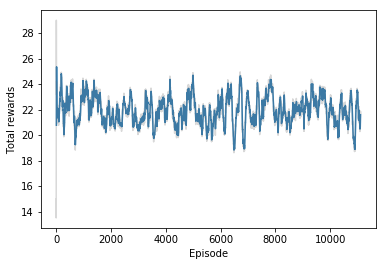

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

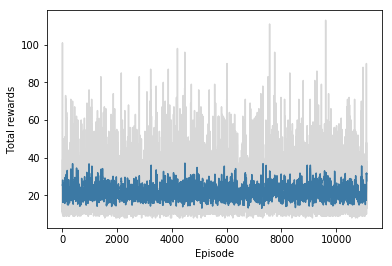

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

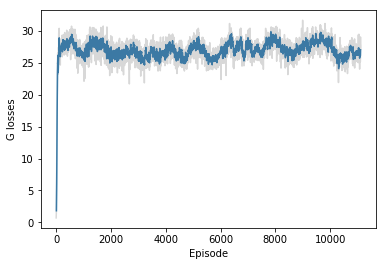

In [35]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

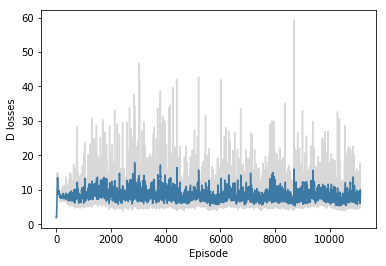

In [36]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.